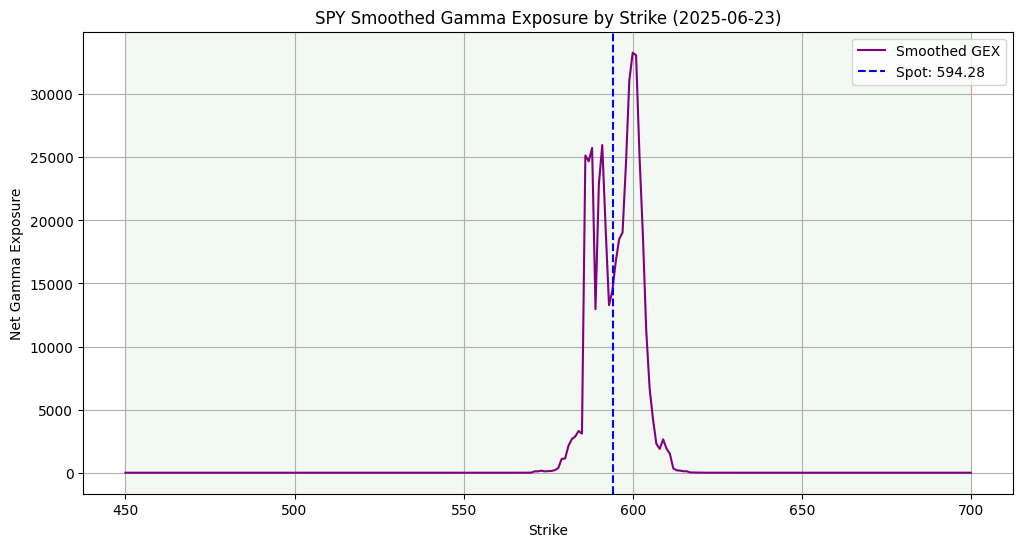

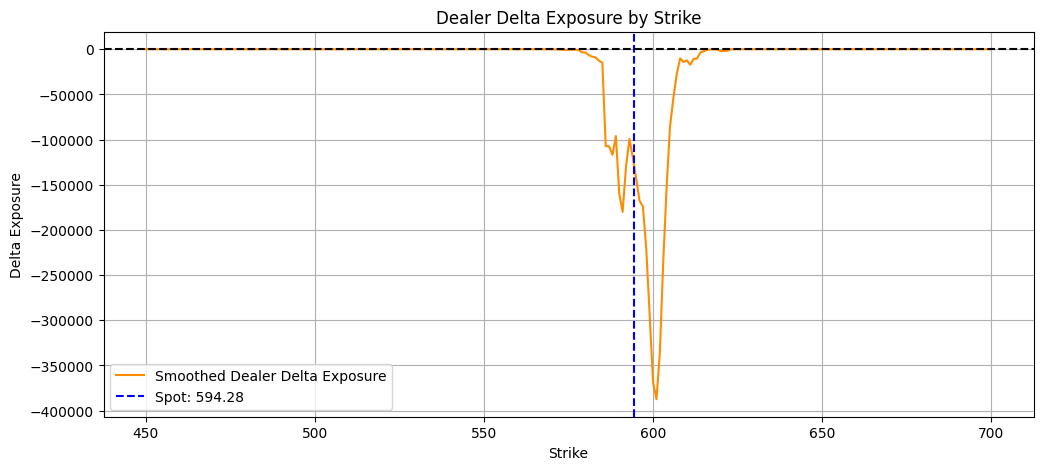

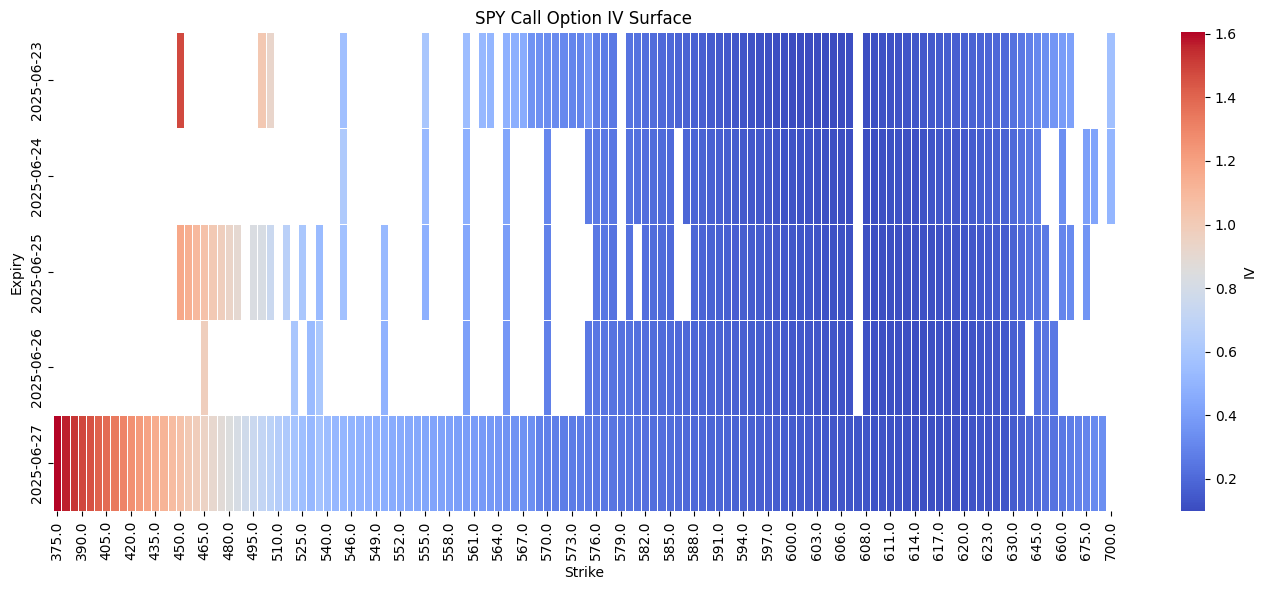


High IV Zones:
   strike      expiry  impliedVolatility
0   375.0  2025-06-27           1.604494
1   380.0  2025-06-27           1.568362
2   385.0  2025-06-27           1.524905
3   390.0  2025-06-27           1.486331
0   450.0  2025-06-23           1.478518
4   395.0  2025-06-27           1.455569
5   400.0  2025-06-27           1.410159
6   405.0  2025-06-27           1.378421
7   410.0  2025-06-27           1.335941
8   415.0  2025-06-27           1.304203


In [44]:
# Gamma Exposure and Volatility Analysis Tool

# Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
import seaborn as sns

# Constants and Parameters
ticker = yf.Ticker("SPY")
expiry = ticker.options[0]
r = 0.05
T = 2 / 365
sigma = 0.15

# Pull Option Chain
df_calls = ticker.option_chain(expiry).calls.copy()
df_puts = ticker.option_chain(expiry).puts.copy()
spot = ticker.history(period="1d")['Close'].iloc[-1]

# Black-Scholes Greeks
def bs_gamma(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def bs_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) if option_type == 'call' else -norm.cdf(-d1)

# Apply Greeks
df_calls['gamma'] = df_calls['strike'].apply(lambda K: bs_gamma(spot, K, T, r, sigma))
df_puts['gamma'] = df_puts['strike'].apply(lambda K: bs_gamma(spot, K, T, r, sigma))

df_calls['delta'] = df_calls['strike'].apply(lambda K: bs_delta(spot, K, T, r, sigma, 'call'))
df_puts['delta'] = df_puts['strike'].apply(lambda K: bs_delta(spot, K, T, r, sigma, 'put'))

# Exposures
df_calls['GEX'] = df_calls['gamma'] * df_calls['openInterest'] * 100
df_puts['GEX'] = df_puts['gamma'] * df_puts['openInterest'] * 100
df_calls['DeltaExposure'] = -df_calls['delta'] * df_calls['openInterest'] * 100
df_puts['DeltaExposure'] = df_puts['delta'] * df_puts['openInterest'] * 100

# Combine and Group
all_gex = pd.concat([df_calls[['strike', 'GEX']], df_puts[['strike', 'GEX']]])
all_delta = pd.concat([df_calls[['strike', 'DeltaExposure']], df_puts[['strike', 'DeltaExposure']]])
gex_by_strike = all_gex.groupby('strike').sum().reset_index()
delta_by_strike = all_delta.groupby('strike').sum().reset_index()

# Smooth
gex_smoothed = gex_by_strike['GEX'].rolling(3, center=True, min_periods=1).mean()
delta_smoothed = delta_by_strike['DeltaExposure'].rolling(3, center=True, min_periods=1).mean()

# Flip Points
flip_strikes = gex_by_strike['strike'][(gex_smoothed * np.roll(gex_smoothed, 1)) < 0]
strikes = gex_by_strike['strike'].values
zones = [strikes[0]] + list(flip_strikes) + [strikes[-1]]

# Plot Gamma Exposure
plt.figure(figsize=(12, 6))
plt.plot(gex_by_strike['strike'], gex_smoothed, color='purple', label='Smoothed GEX')
plt.axvline(spot, color='blue', linestyle='--', label=f'Spot: {spot:.2f}')

for i in range(len(zones) - 1):
    z_start, z_end = zones[i], zones[i+1]
    color = 'green' if i % 2 == 0 else 'red'
    label = 'Long Gamma' if i % 2 == 0 else 'Short Gamma'
    alpha = 0.05 if i % 2 == 0 else 0.08
    plt.axvspan(z_start, z_end, color=color, alpha=alpha)

for strike in flip_strikes:
    plt.axvline(strike, color='orange', linestyle=':')

plt.title(f"SPY Smoothed Gamma Exposure by Strike ({expiry})")
plt.xlabel("Strike")
plt.ylabel("Net Gamma Exposure")
plt.legend()
plt.grid(True)
plt.show()

# Dealer Delta Exposure Plot
plt.figure(figsize=(12, 5))
plt.plot(delta_by_strike['strike'], delta_smoothed, label='Smoothed Dealer Delta Exposure', color='darkorange')
plt.axvline(spot, color='blue', linestyle='--', label=f'Spot: {spot:.2f}')
plt.axhline(0, color='black', linestyle='--')
plt.title("Dealer Delta Exposure by Strike")
plt.xlabel("Strike")
plt.ylabel("Delta Exposure")
plt.grid(True)
plt.legend()
plt.show()

# IV Surface
expiries = ticker.options[:5]
iv_data = []

for exp in expiries:
    chain = ticker.option_chain(exp)
    for df, opt_type in [(chain.calls, 'call'), (chain.puts, 'put')]:
        temp = df[['strike', 'impliedVolatility']].copy()
        temp['expiry'] = exp
        temp['type'] = opt_type
        iv_data.append(temp)

iv_df = pd.concat(iv_data)
call_iv = iv_df[iv_df['type'] == 'call']
iv_pivot = call_iv.pivot_table(index='expiry', columns='strike', values='impliedVolatility')

plt.figure(figsize=(14, 6))
sns.heatmap(iv_pivot, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'IV'})
plt.title("SPY Call Option IV Surface")
plt.xlabel("Strike")
plt.ylabel("Expiry")
plt.tight_layout()
plt.show()

# IV Crush Zones
iv_threshold = 0.30
high_iv = call_iv[call_iv['impliedVolatility'] > iv_threshold]
print("\nHigh IV Zones:")
print(high_iv[['strike', 'expiry', 'impliedVolatility']].sort_values(by='impliedVolatility', ascending=False).head(10))
